In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from time import sleep
from IPython.display import clear_output
from enum import Enum

# QUBO definition


$x_0 = $ forward\
$x_1 = $ top(or left)\
$x_2 = $ down(or right)


$\sum_{i = 0}^{2}{Q_{ii}x_{i}} + P((\sum_{i = 0}^{2}{x_{i}})-1)^2$


In [3]:
def qubo(Q:np.array, P:np.int8) -> np.array:

    assert (Q.shape == (3,3)), "Invalid Q shape. It must be a (3,3) numpy array!!"

    results = {}

    for comb in product([0,1], repeat=3):
        
        linear = 0
        for i in range(3):
            q = Q[i][i]
            linear += q*comb[i]

        penality = 0
        for i in range(3):
            penality += comb[i]
        penality -= 1
        penality = P*(penality**2)

        result = linear + penality

        str_comb = ''.join(map(str, comb))
        results[str_comb] = result

    min_key = min(results, key=results.get)
    min_val = results[min_key]
    
    return min_key, min_val, results
    
qubo(np.ones((3,3)), 4)

('001',
 1.0,
 {'000': 4.0,
  '001': 1.0,
  '010': 1.0,
  '011': 6.0,
  '100': 1.0,
  '101': 6.0,
  '110': 6.0,
  '111': 19.0})

In [35]:
class Directions(Enum):
    RIGHT=0
    LEFT=1
    UP=2
    DOWN=3

In [3]:
class BoardElement:
    def __init__(self, i, j, element_num):
        self.i = i
        self.j = j
        self.num = element_num

    def add_to_board(self, board):
        board[self.i][self.j] = self.num

In [4]:
class Player(BoardElement):
    def __init__(self, i, j, element_num, direction):
        super().__init__(i, j, element_num)
        self.direction = direction

class Food(BoardElement):
    pass

In [48]:
class Game:
    def __init__(self, board_w, board_h, qubo, P):
        self.board_w = board_w
        self.board_h = board_h
        self.qubo = qubo
        self.P = P

    def set_player(self, i, j, direction):
        self.player = Player(i,j,1,direction)

    def set_food(self,i, j):
        self.food = Food(i,j,2)

    def update_board(self):
        self.board = np.zeros((self.board_w, self.board_h))
        self.player.add_to_board(self.board)
        self.food.add_to_board(self.board)
        

    def calculate_distance(self, pi, pj):
        dx = self.food.i - pi
        dy = self.food.j - pj
        return np.sqrt(dx**2 + dy**2)

    def calculate_best_next_position(self):
        best_movement = None
        match self.player.direction:
            case Directions.RIGHT:
                best_movement = self.best_from_right()
                
            case Directions.LEFT:
                best_movement = self.best_from_left()
                
            case Directions.UP:
                best_movement = self.best_from_up()
            
            case Directions.DOWN:
                best_movement = self.best_from_down()
                
            case _:
                raise Exception("Invalid direciton!")

        match best_movement:
            case '001':
                return 'down/right'
            case '010':
                return 'up/left'
            case '100':
                return 'forward'
            case _:
                raise Exception("Invalid movement")

    def best_from_right(self):
        x0 = x1 = x2 = 0

        pi = self.player.i
        pj = self.player.j
        
        if(self.at_the_right_wall()):
            x0 = 1000
        else:
            x0 = self.calculate_distance(pi, pj+1)

        if(self.at_the_top_wall()):
            x1 = 1000
        else:
            x1 = self.calculate_distance(pi-1, pj)

        if(self.at_the_bottom_wall()):
            x2 = 1000
        else:
            x2 = self.calculate_distance(pi+1, pj)

        min_, _, __ = self.qubo(self.generate_Q(x0, x1, x2), self.P)
        return min_

    def best_from_left(self):
        x0 = x1 = x2 = 0

        pi = self.player.i
        pj = self.player.j
        
        if(self.at_the_left_wall()):
            x0 = 1000
        else:
            x0 = self.calculate_distance(pi, pj-1)

        if(self.at_the_top_wall()):
            x1 = 1000
        else:
            x1 = self.calculate_distance(pi-1, pj)

        if(self.at_the_bottom_wall()):
            x2 = 1000
        else:
            x2 = self.calculate_distance(pi+1, pj)

        min_, _, __ = self.qubo(self.generate_Q(x0, x1, x2), self.P)
        return min_

    def best_from_down(self):
        x0 = x1 = x2 = 0

        pi = self.player.i
        pj = self.player.j
        
        if(self.at_the_bottom_wall()):
            x0 = 1000
        else:
            x0 = self.calculate_distance(pi+1, pj)

        if(self.at_the_left_wall()):
            x1 = 1000
        else:
            x1 = self.calculate_distance(pi, pj-1)

        if(self.at_the_right_wall()):
            x2 = 1000
        else:
            x2 = self.calculate_distance(pi, pj+1)

        min_, _, __ = self.qubo(self.generate_Q(x0, x1, x2), self.P)
        return min_

    def best_from_up(self):
        x0 = x1 = x2 = 0

        pi = self.player.i
        pj = self.player.j
        
        if(self.at_the_top_wall()):
            x0 = 1000
        else:
            x0 = self.calculate_distance(pi-1, pj)

        if(self.at_the_left_wall()):
            x1 = 1000
        else:
            x1 = self.calculate_distance(pi, pj-1)

        if(self.at_the_right_wall()):
            x2 = 1000
        else:
            x2 = self.calculate_distance(pi, pj+1)

        min_, _, __ = self.qubo(self.generate_Q(x0, x1, x2), self.P)
        return min_
        

    def at_the_right_wall(self):
        return self.player.j == self.board_w-1
        
    def at_the_top_wall(self):
        return self.player.i == 0

    def at_the_bottom_wall(self):
        return self.player.j == self.board_h-1

    def at_the_left_wall(self):
        return self.player.j == 0

    def generate_Q(self, x0, x1, x2):
        return np.array([
            [x0, 0, 0],
            [0, x1, 0],
            [0, 0, x2]
        ])
        
        
    def show(self):
        display(plt.imshow(self.board))

    def play(self):
        try:
            while(not self.died() and not self.caught_food()):
                movement = self.calculate_best_next_position()
    
                match movement:
                    case 'down/right':
                        self.move_down_right()
                    case 'up/left':
                        self.move_up_left()
                    case 'forward':
                        self.move_forward()
                    case _:
                        raise Exception("Invalid movement!")
                        
                print(f'next movement: {movement}')
                print(f'player direction: {self.player.direction}')
                print(f'died: {self.died()}')
                print(f'caught food: {self.caught_food()}')
                self.update_board()
                
                self.show()
                plt.show()
                sleep(1)
                clear_output(wait=True)
        
        except Exception as error:
            print(f"An error ocourred: {str(error)}")

    def move_down_right(self):
        match self.player.direction:
            case Directions.RIGHT | Directions.LEFT:
                self.player.i += 1
                self.player.direction = Directions.DOWN
            case Directions.UP | Directions.DOWN:
                self.player.j += 1
                self.player.direction = Directions.RIGHT
            case _:
                raise Exception("Invalid down|right movement")
                
    def move_up_left(self):
        match self.player.direction:
            case Directions.RIGHT | Directions.LEFT:
                self.player.i -= 1
                self.player.direction = Directions.UP
            case Directions.UP | Directions.DOWN:
                self.player.j -= 1
                self.player.direction = Directions.LEFT
            case _:
                raise Exception("Invalid up|left movement")

    def move_forward(self):
        match self.player.direction:
            case Directions.RIGHT:
                self.player.j += 1
            case Directions.LEFT:
                self.player.j -= 1
            case Directions.UP:
                self.player.i -= 1
            case Directions.DOWN:
                self.player.i += 1
            case _:
                raise Exception("Invalid forward movement")
            
    
    def died(self):
        return self.player.i < 0 or self.player.i > self.board_h or self.player.j < 0 or self.player.j > self.board_w

    def caught_food(self):
        return self.player.i == self.food.i and self.food.j == self.player.j

next movement: down/right
player direction: Directions.RIGHT
died: False
caught food: True


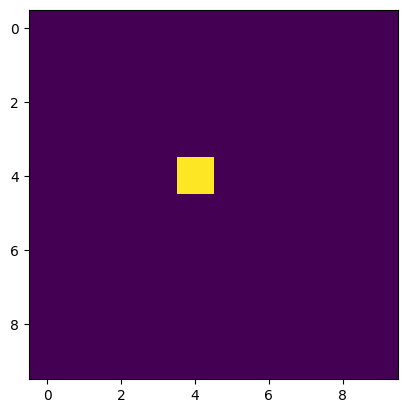

In [54]:
game = Game(10, 10, qubo, 10)
game.set_player(8,0, Directions.RIGHT)
game.set_food(4,4)
game.play()